In [0]:
from google.colab import drive
drive.mount('/content/gdrive') # 點擊網址，選擇 Google 帳號登入，然後將授權碼貼回輸入框中

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
!ln -fs /content/gdrive/My\ Drive/Colab\ Notebooks/Datascience /app

In [0]:
!tar -xzvf /app/cuDNN/cudnn-10.0-linux-x64-v7.5.0.56.tgz -C /usr/local/
!chmod a+r /usr/local/cuda/include/cudnn.h

# 檢查是否安裝成功
!cat /usr/local/cuda/include/cudnn.h | grep CUDNN_MAJOR -A 2

cuda/include/cudnn.h
cuda/NVIDIA_SLA_cuDNN_Support.txt
cuda/lib64/libcudnn.so
cuda/lib64/libcudnn.so.7
cuda/lib64/libcudnn.so.7.5.0
cuda/lib64/libcudnn_static.a
#define CUDNN_MAJOR 7
#define CUDNN_MINOR 5
#define CUDNN_PATCHLEVEL 0
--
#define CUDNN_VERSION (CUDNN_MAJOR * 1000 + CUDNN_MINOR * 100 + CUDNN_PATCHLEVEL)

#include "driver_types.h"


<pre>
電力生產和消耗以千兆瓦時（GWh）的每日總量報告。數據文件的列為：
input/opsd_germany_daily.csv

Date—日期（yyyy-mm-dd格式）
Consumption —用電量（GWh）
Wind — GWh中的風力發電
Solar — GWh中的太陽能發電
Wind+Solar —風電和太陽能發電量的總和
我們將使用熊貓時間序列工具來回答德國的電力消耗和生產隨時間的變化，這些問題包括：

通常什麼時候耗電量最高和最低？
風力和太陽能發電如何隨一年的季節而變化？
電力消耗，太陽能和風能的長期趨勢是什麼？
風能和太陽能發電與電能消耗如何比較，該比率隨時間變化如何？
</pre>

In [0]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

In [0]:
opsd_daily = pd.read_csv('/app/input/opsd_germany_daily.csv')
opsd_daily.shape

(4383, 5)

In [0]:
opsd_daily.head(3)

,Date,Consumption,Wind,Solar,Wind+Solar
0,2006-01-01,1069.184,NaN,NaN,NaN
1,2006-01-02,1380.521,NaN,NaN,NaN
2,2006-01-03,1442.533,NaN,NaN,NaN


In [0]:
opsd_daily.tail(3)

,Date,Consumption,Wind,Solar,Wind+Solar
4380,2017-12-29,1295.08753,584.277,29.854,614.131
4381,2017-12-30,1215.44897,721.247,7.467,728.714
4382,2017-12-31,1107.11488,721.176,19.980,741.156


In [0]:
opsd_daily.dtypes

Date            object
Consumption    float64
Wind           float64
Solar          float64
Wind+Solar     float64
dtype: object

In [0]:
opsd_daily = opsd_daily.set_index('Date')
opsd_daily.head(3)

,Consumption,Wind,Solar,Wind+Solar
Date,,,,
2006-01-01,1069.184,NaN,NaN,NaN
2006-01-02,1380.521,NaN,NaN,NaN
2006-01-03,1442.533,NaN,NaN,NaN


In [0]:
opsd_daily.index

Index(['2006-01-01', '2006-01-02', '2006-01-03', '2006-01-04', '2006-01-05',
       '2006-01-06', '2006-01-07', '2006-01-08', '2006-01-09', '2006-01-10',
       ...
       '2017-12-22', '2017-12-23', '2017-12-24', '2017-12-25', '2017-12-26',
       '2017-12-27', '2017-12-28', '2017-12-29', '2017-12-30', '2017-12-31'],
      dtype='object', name='Date', length=4383)

<pre>
我們可以使用函數的index_col和parse_dates參數將以上步驟合併為一行read_csv()。這通常是一個有用的快捷方式。
</pre>

In [0]:
opsd_daily = pd.read_csv('/app/input/opsd_germany_daily.csv', index_col=0, parse_dates=True)

In [0]:
# Add columns with year, month, and weekday name
opsd_daily['Year'] = opsd_daily.index.year
opsd_daily['Month'] = opsd_daily.index.month
opsd_daily['Weekday Name'] = opsd_daily.index.weekday_name
# Display a random sampling of 5 rows
opsd_daily.sample(5, random_state=0)

,Consumption,Wind,Solar,Wind+Solar,Year,Month,Weekday Name
Date,,,,,,,
2008-08-23,1152.011,NaN,NaN,NaN,2008,8,Saturday
2013-08-08,1291.984,79.666,93.371,173.037,2013,8,Thursday
2009-08-27,1281.057,NaN,NaN,NaN,2009,8,Thursday
2015-10-02,1391.050,81.229,160.641,241.870,2015,10,Friday
2009-06-02,1201.522,NaN,NaN,NaN,2009,6,Tuesday


In [0]:
opsd_daily.loc['2017-08-10']

Consumption      1351.49
Wind             100.274
Solar              71.16
Wind+Solar       171.434
Year                2017
Month                  8
Weekday Name    Thursday
Name: 2017-08-10 00:00:00, dtype: object

In [0]:
opsd_daily.loc['2014-01-20':'2014-01-22']

,Consumption,Wind,Solar,Wind+Solar,Year,Month,Weekday Name
Date,,,,,,,
2014-01-20,1590.687,78.647,6.371,85.018,2014,1,Monday
2014-01-21,1624.806,15.643,5.835,21.478,2014,1,Tuesday
2014-01-22,1625.155,60.259,11.992,72.251,2014,1,Wednesday


In [0]:
opsd_daily.loc['2012-02']

,Consumption,Wind,Solar,Wind+Solar,Year,Month,Weekday Name
Date,,,,,,,
2012-02-01,1511.866,199.607,43.502,243.109,2012,2,Wednesday
2012-02-02,1563.407,73.469,44.675,118.144,2012,2,Thursday
2012-02-03,1563.631,36.352,46.510,82.862,2012,2,Friday
2012-02-04,1372.614,20.551,45.225,65.776,2012,2,Saturday
2012-02-05,1279.432,55.522,54.572,110.094,2012,2,Sunday
2012-02-06,1574.766,34.896,55.389,90.285,2012,2,Monday
2012-02-07,1615.078,100.312,19.867,120.179,2012,2,Tuesday
2012-02-08,1613.774,93.763,36.930,130.693,2012,2,Wednesday
2012-02-09,1591.532,132.219,19.042,151.261,2012,2,Thursday


In [0]:
import matplotlib.pyplot as plt
# Display figures inline in Jupyter notebook

In [0]:
import seaborn as sns
# Use seaborn style defaults and set the default figure size
sns.set(rc={'figure.figsize':(11, 4)})

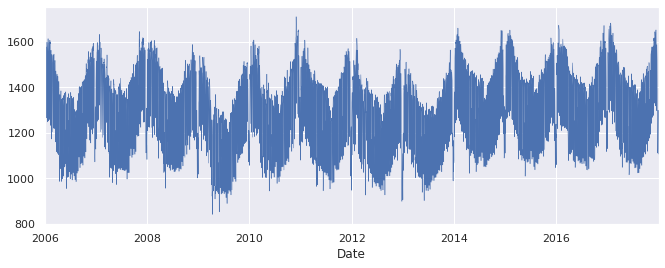

In [0]:
opsd_daily['Consumption'].plot(linewidth=0.5);

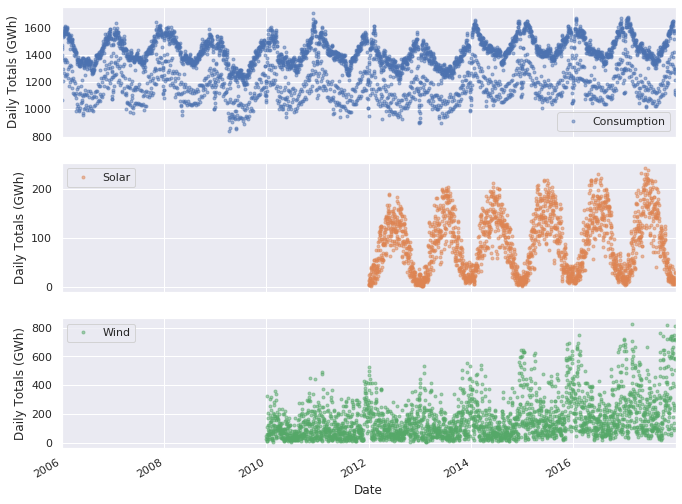

In [0]:
cols_plot = ['Consumption', 'Solar', 'Wind']
axes = opsd_daily[cols_plot].plot(marker='.', alpha=0.5, linestyle='None', figsize=(11, 9), subplots=True)
for ax in axes:
    ax.set_ylabel('Daily Totals (GWh)')

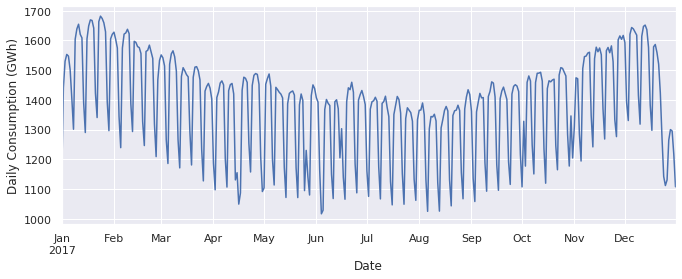

In [0]:
ax = opsd_daily.loc['2017', 'Consumption'].plot()
ax.set_ylabel('Daily Consumption (GWh)');